### The recorded audio is missing some samples for each trial. A quick solutioin for alignment is to just pad zeros to the recordings.

In [23]:
from speech_pinyin.config import *
import glob
from scipy.io import wavfile
import matplotlib.pylab as plt
import mne
import numpy as np
from utils.util_MNE import keep_annotation
import itertools

In [24]:
sid=1
folder=data_dir+str(sid)+'-*'
folder=os.path.normpath(glob.glob(folder)[0])
folder=folder.replace("\\", "/")
audio_folder=folder+'/raw/matlab/result/'
files=['name_202408280901','name_202408280930','name_202408280959']

In [25]:
session=3
file=audio_folder+files[session-1]+'/recording.wav'
sf_audio,audio=wavfile.read(file)

C:\Users\xiaowu\AppData\Local\Temp\ipykernel_55064\2686718653.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sf_audio,audio=wavfile.read(file)


In [26]:
trial_begins=[]
beep=[1,0,1,0,1,0]
index=0
while index<len(audio)-10:
    if all(audio[index:index+6]==beep):
        trial_begins.append(index+6)
        index=index+5*48000 # jump before step-by-step search
    index=index+1
print(len(trial_begins))

144


In [27]:
# remove the beep
audio_clean=[]
lengths=[]
for i in range(len(trial_begins)-1):
    if i==len(trial_begins)-1:
        trial_start=trial_begins[i]
        tmp=audio[trial_start:]
    else:
        trial_start=trial_begins[i]
        trial_stop=trial_begins[i+1]-6
        tmp=audio[trial_start:trial_stop]
    length=len(tmp)
    lengths.append(length/48000)
    audio_clean.append(tmp)
print(len(audio_clean))

143


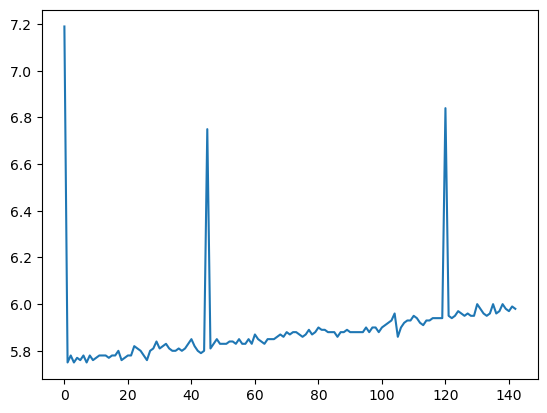

In [12]:
plt.plot(lengths)

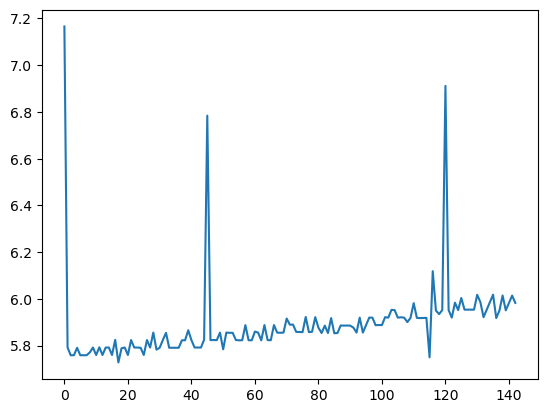

In [14]:
lengths2=np.load(folder+'/processed/session3'+'_trial_length_EEG.npy', allow_pickle=True) # 144
lengths2=lengths2[:-1]
plt.plot(lengths2)

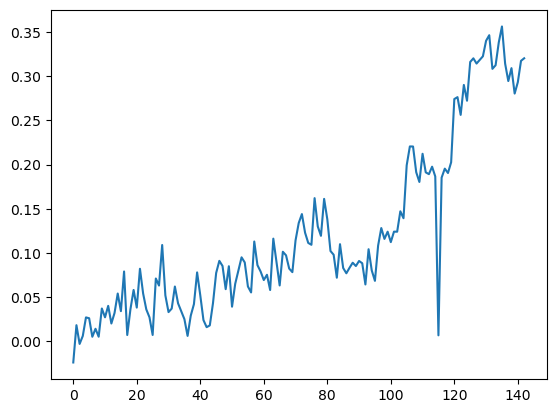

In [15]:
differences=[lengths2[i]-lengths[i] for i in range(len(lengths2))]
accum=np.cumsum(differences)#
plt.plot(accum)

In [58]:
# padding the audio data
import math
audio_clean2=[]
lengths3=[]
for i in range(len(trial_begins)-1):
    if i==len(trial_begins)-1:
        trial_start=trial_begins[i]
        tmp=audio[trial_start:]
    else:
        trial_start=trial_begins[i]
        trial_stop=int(trial_start+lengths2[i]*48000)#trial_begins[i+1]-6
        tmp=audio[trial_start:trial_stop+12]
    length=len(tmp)
    lengths3.append(length/48000)
    audio_clean2.append(tmp)
print(len(audio_clean2))

143


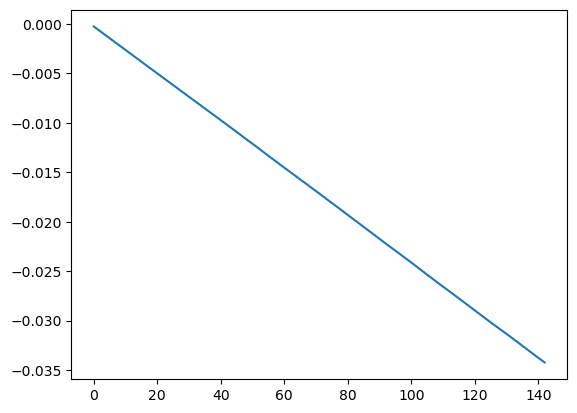

In [59]:
differences2=[lengths2[i]-lengths3[i] for i in range(len(lengths2))]
accum=np.cumsum(differences2)#
plt.plot(accum)

In [60]:
# stitch up the audio data
tmp=np.asarray(list(itertools.chain(*audio_clean2)))
print(len(tmp)/48000) #ceil:842.3416666666667  #floor: 842.3388125  EEG: 842.376

842.3745625


In [61]:

filename=folder+'/processed/session'+str(session)+'_clean_padded_no_last_trial.wav'
wavfile.write(filename,48000,tmp)